In [1]:
using Plots
using Random: MersenneTwister
using StatsBase: mean

include("../src/Simulation.jl")
using .Simulation: Param, Model, run!

include("../src/ColorScheme.jl")
using .ColorScheme
const CS = ColorScheme

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
default(
    fontfamily="Arial",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    dpi=600,
);

In [3]:
function moving_average(data::Vector{<:Real}, window_size::Int = 10)::Vector{Float64}
    return [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
end

function calc_prime_node_shift_vec(peak_node_vec::Vector{Int})::Vector{Float64}
    shift_vec = peak_node_vec[2:end] .- peak_node_vec[1:(end-1)]
    shift_vec = Float64.(abs.(shift_vec))
    shift_vec = [x > 50 ? 100 - x : x for x in shift_vec]

    return shift_vec
end

function line_color(σR::Int)::String
    return if σR == 16
        CS.RED
    elseif σR == 4
        CS.BLUE
    else
        CS.BLACK
    end
end;

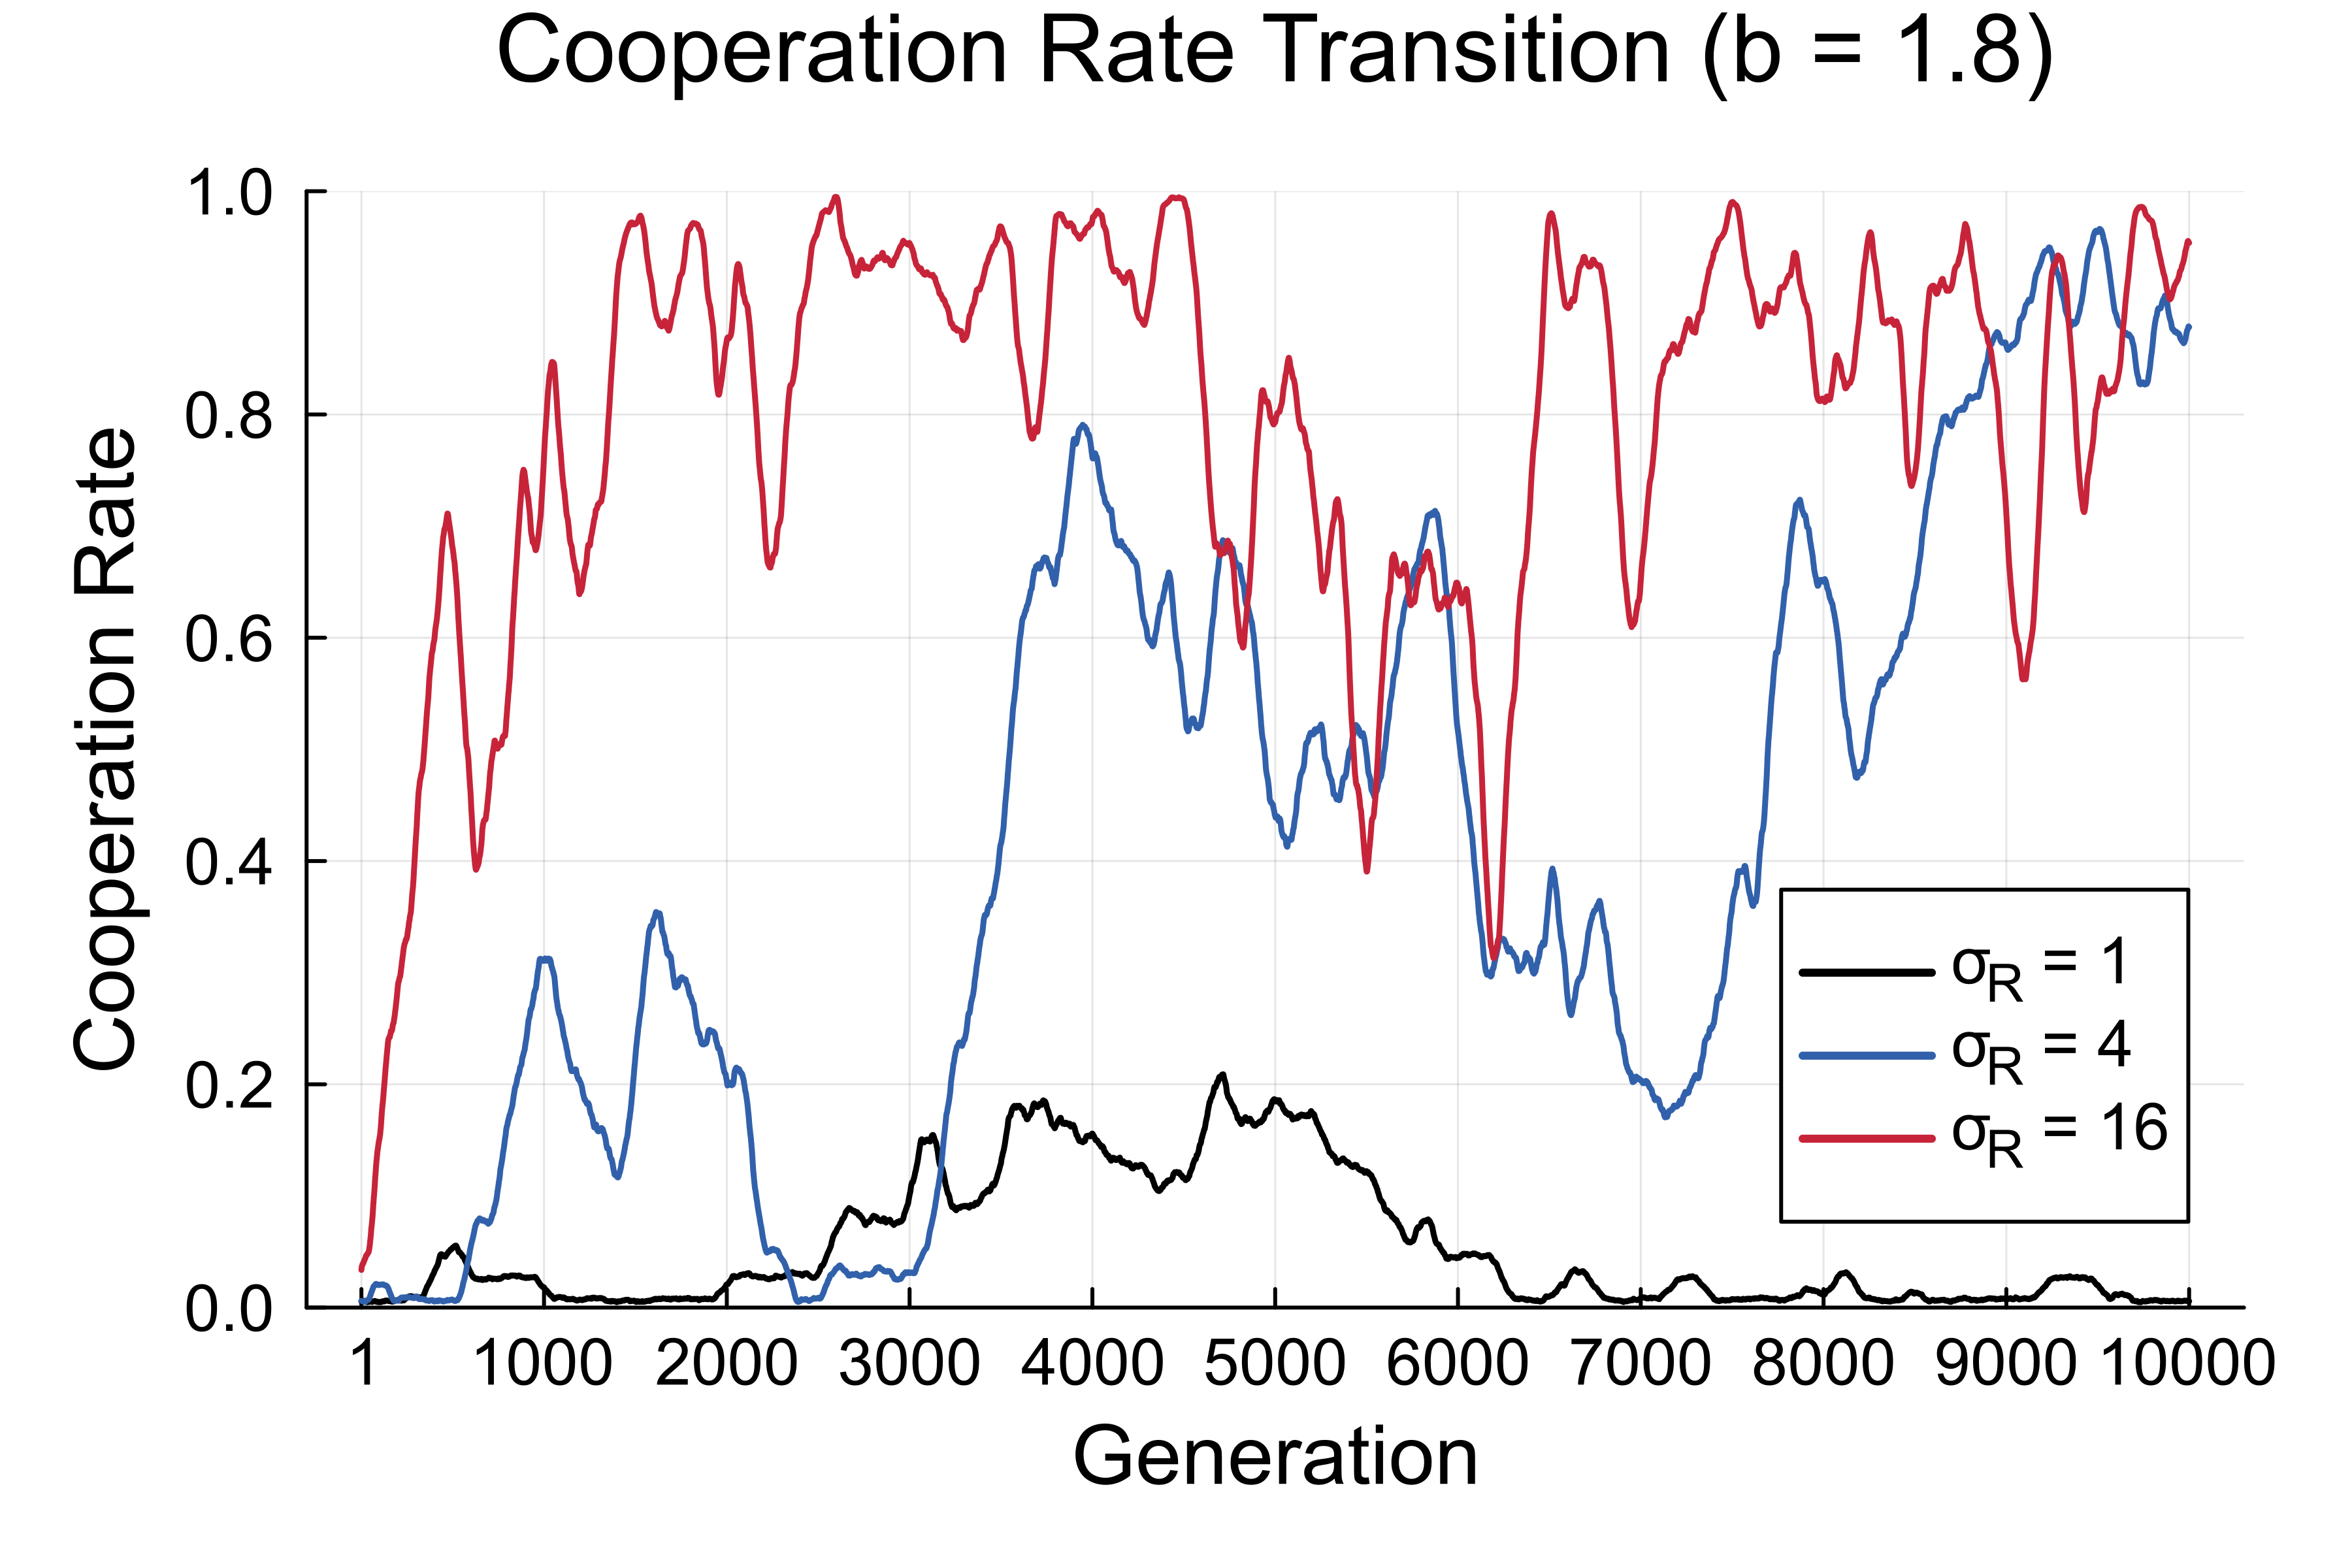

In [4]:
C_rate₀ = 0.0
b = 1.8
relationship_increment_factor = 1.0
resource_decrement_factor = 0.02
resource_limit_μ = 0.5
resource_limit_β = 0.0
resource_limit_σ = 0.0
peak_node_variability_vec = [1, 4, 16]

random_seed = 1
generations = 10_000
window_size = 50

xticks = collect(0:1000:generations)
xticks[1] = 1

plt = plot(
    xlabel="Generation", xticks=xticks,
    ylabel="Cooperation Rate", ylim=(0, 1),
    title="Cooperation Rate Transition (b = $(b))", legend=(0.85, 0.3),
)

for σR in peak_node_variability_vec
    p = Param(
        N = 100, k₀ = 4, generations = generations, b = b, C_rate₀ = C_rate₀,
        peak_node_variability = σR,
        relationship_increment_factor = relationship_increment_factor,
        resource_decrement_factor = resource_decrement_factor,
        resource_limit_μ = resource_limit_μ,
        resource_limit_β = resource_limit_β,
        resource_limit_σ = resource_limit_σ,
    )
    m = Model(p, MersenneTwister(random_seed))
    C_rate_vec, _, _, peak_node_vec = run!(m, MersenneTwister(random_seed))
    pushfirst!(peak_node_vec, 1)

    plot!(moving_average(C_rate_vec, window_size), label="\\sigma_{R} = $(σR)", lc=line_color(σR), lw=1.5)
end

display(plt)
savefig("img/Fig2b.png");